#### Install Pakages 

In [ ]:
pip install yfinance

In [ ]:
pip install statsmodels

In [ ]:
pip install pmdarima

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline


from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Processing data

##### Download stock data

In [2]:
# Baixar dados históricos usando yfinance
symbol = 'BBAS3.SA'  # Símbolo da ação desejada aqui 
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days = 729)
interval = '1h'
stock_data_hour = yf.download(symbol, start=start_date, end=end_date, interval=interval)
stock_data_day = yf.download(symbol, start=start_date, end=end_date)

display(stock_data_day)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-20,29.969999,29.969999,29.240000,29.420000,25.361639,21291400
2021-12-21,29.750000,30.100000,29.500000,29.500000,25.430605,11766900
2021-12-22,29.600000,29.650000,29.160000,29.330000,25.284054,12478200
2021-12-23,29.299999,29.480000,29.160000,29.219999,25.189228,7337800
2021-12-27,29.250000,29.490000,29.200001,29.280001,25.240950,5746200
...,...,...,...,...,...,...
2023-12-12,53.799999,53.799999,52.410000,52.500000,52.500000,12531800
2023-12-13,52.470001,53.259998,51.639999,52.980000,52.980000,18080000
2023-12-14,53.500000,53.560001,52.400002,53.330002,53.330002,18436600


In [3]:
stock_data_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2021-12-17 to 2023-12-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       499 non-null    float64
 1   High       499 non-null    float64
 2   Low        499 non-null    float64
 3   Close      499 non-null    float64
 4   Adj Close  499 non-null    float64
 5   Volume     499 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.3 KB


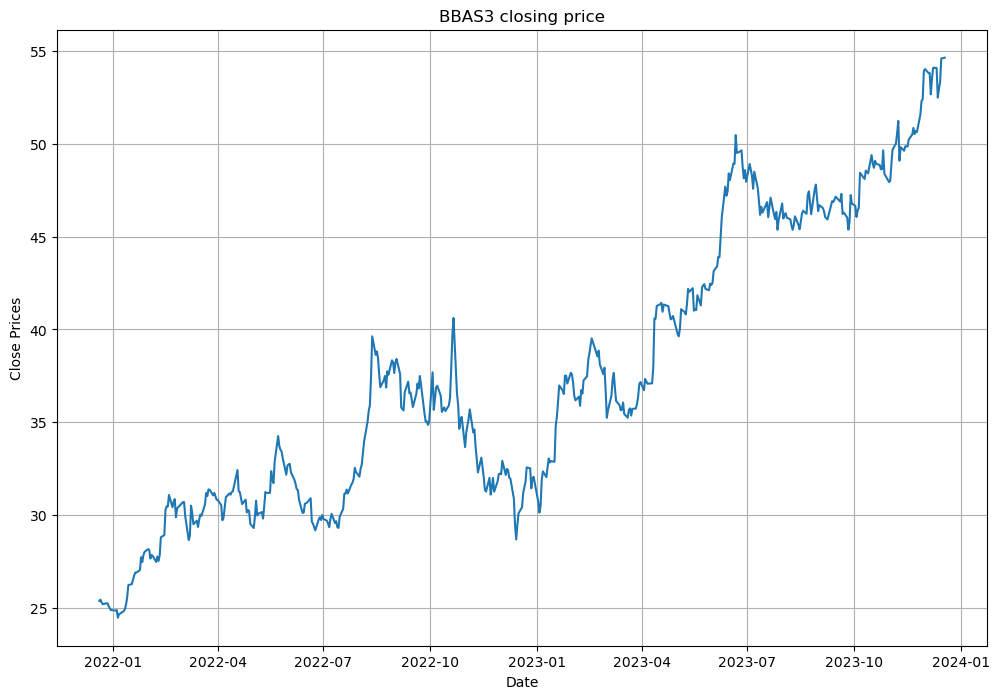

In [3]:
#plot close price
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data_day['Adj Close'])
plt.title('BBAS3 closing price')
plt.show()

In [4]:
data = stock_data_day[["Adj Close"]].copy()

c:\Users\chico\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


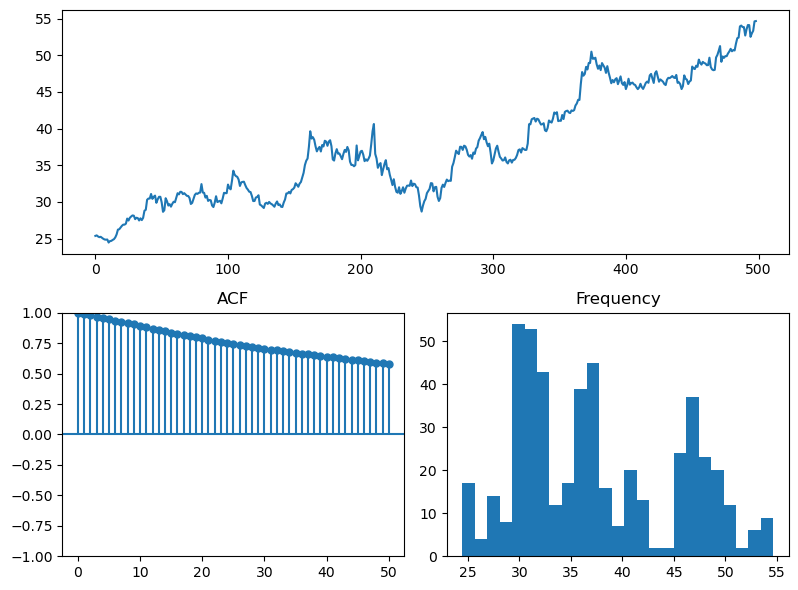

In [5]:
tsdisplay(data)

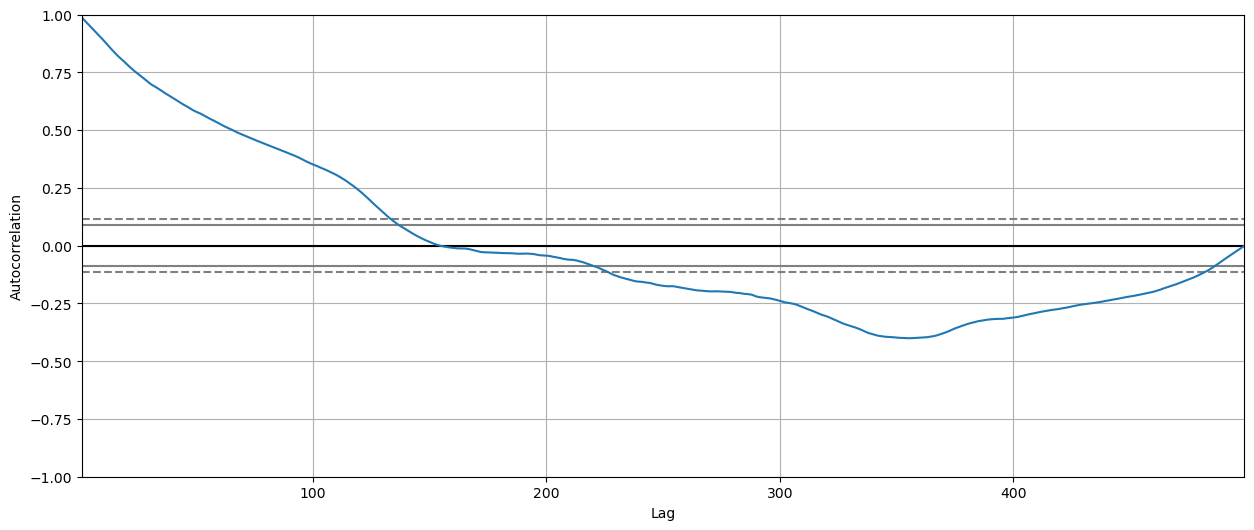

In [6]:
autocorr_plot(data)

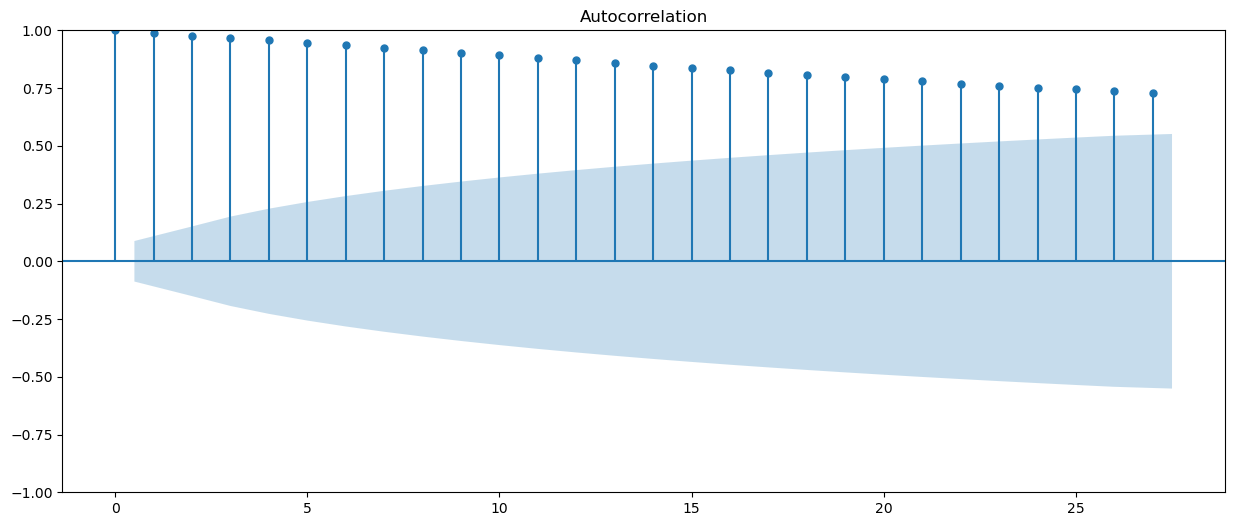

In [7]:
plot_acf(data, alpha=0.05)

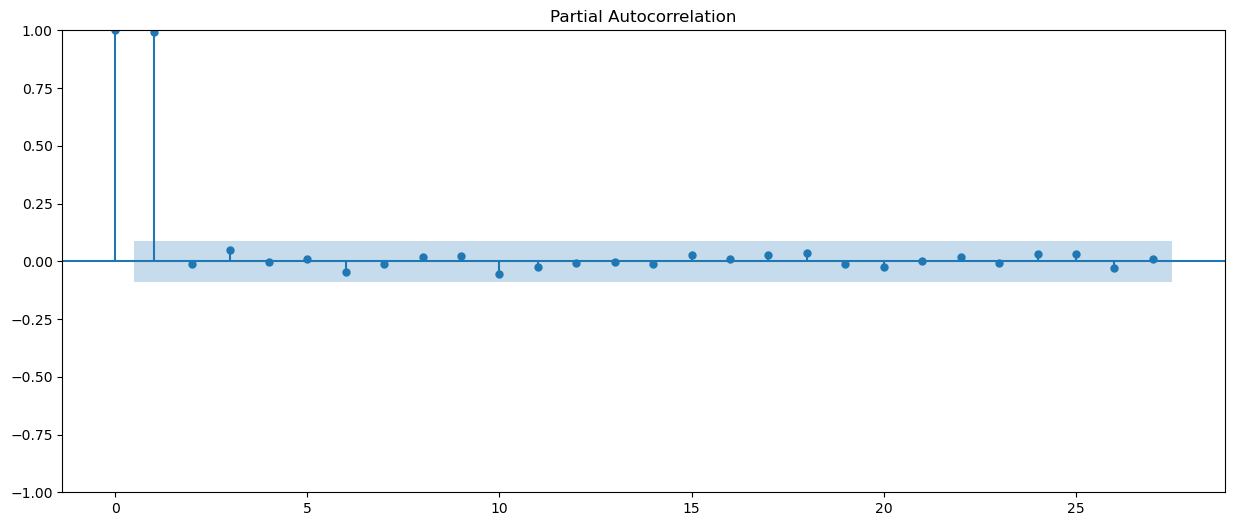

In [10]:
plot_pacf(data, alpha=0.05)

##### AutoARIMA 

In [11]:
stepwise=auto_arima(data,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=40,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[40] intercept   : AIC=inf, Time=16.40 sec
 ARIMA(0,0,0)(0,1,0)[40] intercept   : AIC=2515.671, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[40] intercept   : AIC=1142.725, Time=6.03 sec
 ARIMA(0,0,1)(0,1,1)[40] intercept   : AIC=inf, Time=13.08 sec
 ARIMA(0,0,0)(0,1,0)[40]             : AIC=2644.497, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[40] intercept   : AIC=1255.485, Time=1.03 sec
 ARIMA(1,0,0)(2,1,0)[40] intercept   : AIC=1104.500, Time=16.27 sec
 ARIMA(1,0,0)(2,1,1)[40] intercept   : AIC=inf, Time=43.84 sec
 ARIMA(1,0,0)(1,1,1)[40] intercept   : AIC=inf, Time=19.69 sec
 ARIMA(0,0,0)(2,1,0)[40] intercept   : AIC=2427.094, Time=17.28 sec
 ARIMA(2,0,0)(2,1,0)[40] intercept   : AIC=1106.422, Time=23.31 sec
 ARIMA(1,0,1)(2,1,0)[40] intercept   : AIC=1106.418, Time=42.81 sec
 ARIMA(0,0,1)(2,1,0)[40] intercept   : AIC=1945.452, Time=25.05 sec
 ARIMA(2,0,1)(2,1,0)[40] intercept   : AIC=1107.832, Time=76.65 sec
 ARIMA(1,0,0)(2,1,0)[40]     

In [40]:
stepwise

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 40),
      suppress_warnings=True)

In [12]:
print(stepwise.aic())
print(stepwise.bic())

1104.4995090388784
1125.144760089181


In [13]:
display(data)

,Adj Close
Date,
2021-12-20,25.361639
2021-12-21,25.430605
2021-12-22,25.284054
2021-12-23,25.189228
2021-12-27,25.240950
...,...
2023-12-12,52.500000
2023-12-13,52.980000
2023-12-14,53.330002


In [205]:
display(data['2023-06-09 10:00:00-03:00':"2023-06-13 10:00:00-03:00"])
data.describe()

,Adj Close
2023-06-09 10:00:00-03:00,45.930000
2023-06-09 11:00:00-03:00,46.279999
2023-06-09 12:00:00-03:00,46.599998
2023-06-09 13:00:00-03:00,46.959999
2023-06-09 14:00:00-03:00,47.060001
2023-06-09 15:00:00-03:00,47.169998
2023-06-09 16:00:00-03:00,47.680000
2023-06-12 10:00:00-03:00,48.480000
2023-06-12 11:00:00-03:00,49.419998
2023-06-12 12:00:00-03:00,49.139999


,Adj Close
count,3489.000000
mean,39.922310
std,6.391318
min,28.360001
25%,34.639999
50%,38.990002
75%,46.310001
max,54.720001


In [14]:
metade_linhas = len(data) // 2

#treino=data.iloc[:metade_linhas, :]
#teste=data.iloc[metade_linhas:, :]
treino=data['2022-12-20':"2023-11-20"]
teste=data["2023-11-21":]

In [15]:
teste.shape

(20, 1)

In [16]:
stepwise.fit(treino)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 40),
      suppress_warnings=True)

In [17]:
previsao=stepwise.predict(n_periods=20)

c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
#Transformando a previsão em um DataFrame
previsao_final=pd.DataFrame(previsao.values,index=teste.index, columns=["Adj Close"])
#previsao_final = pd.DataFrame({'Adj Close': previsao.values}, index=teste.index)
#previsao_final = pd.merge(teste, previsao_df, left_index=True, right_index=True, how='left')
#resultado_final = pd.merge(treino, previsao.to_frame(name="Previsao"), left_index=True, right_index=True, how='left')
#resultado_final = pd.concat([teste, previsao_df['Adj Close']], axis=1)
#resultado_final = pd.merge(teste, previsao_df[['Adj Close']], how='left')


In [19]:
display(previsao_final)

,Adj Close
Date,
2023-11-21,50.080850
2023-11-22,49.890764
2023-11-23,49.928486
2023-11-24,49.918425
2023-11-27,50.000625
2023-11-28,51.008355
2023-11-29,50.792375
2023-11-30,51.006675
2023-12-01,50.924107


<Figure size 2000x500 with 0 Axes>

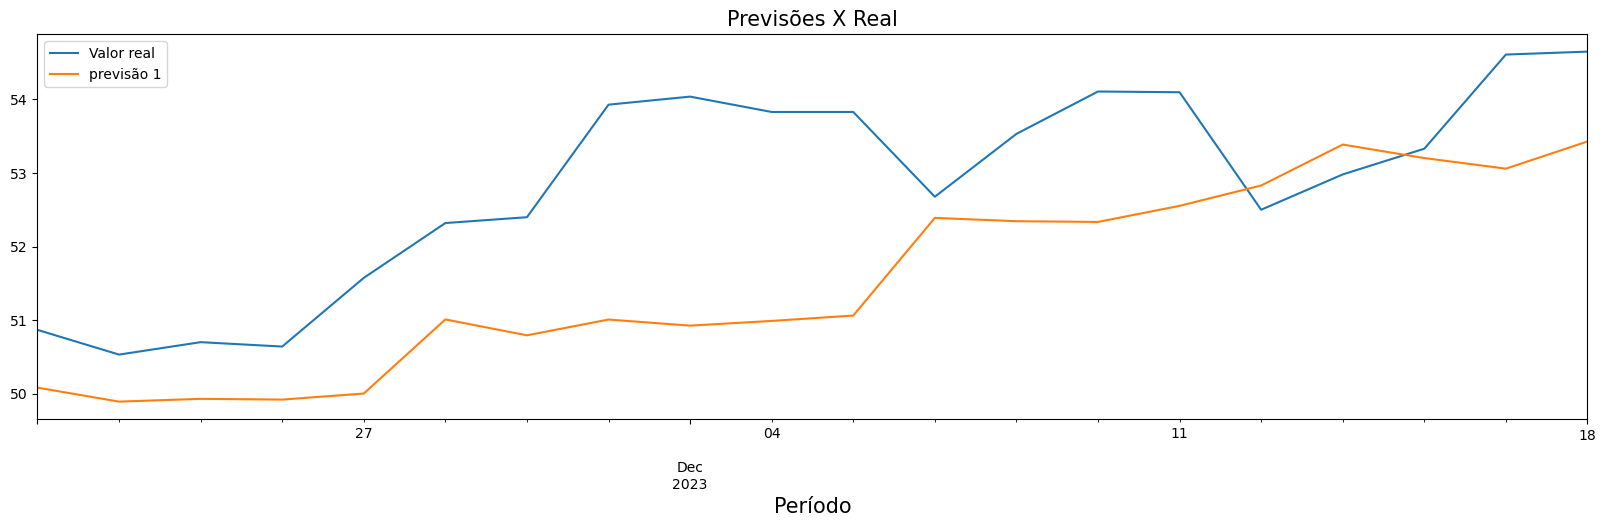

In [20]:
plt.figure(figsize=(20,5))
pd.concat([teste,previsao_final],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1'])

- diminuir o treino 

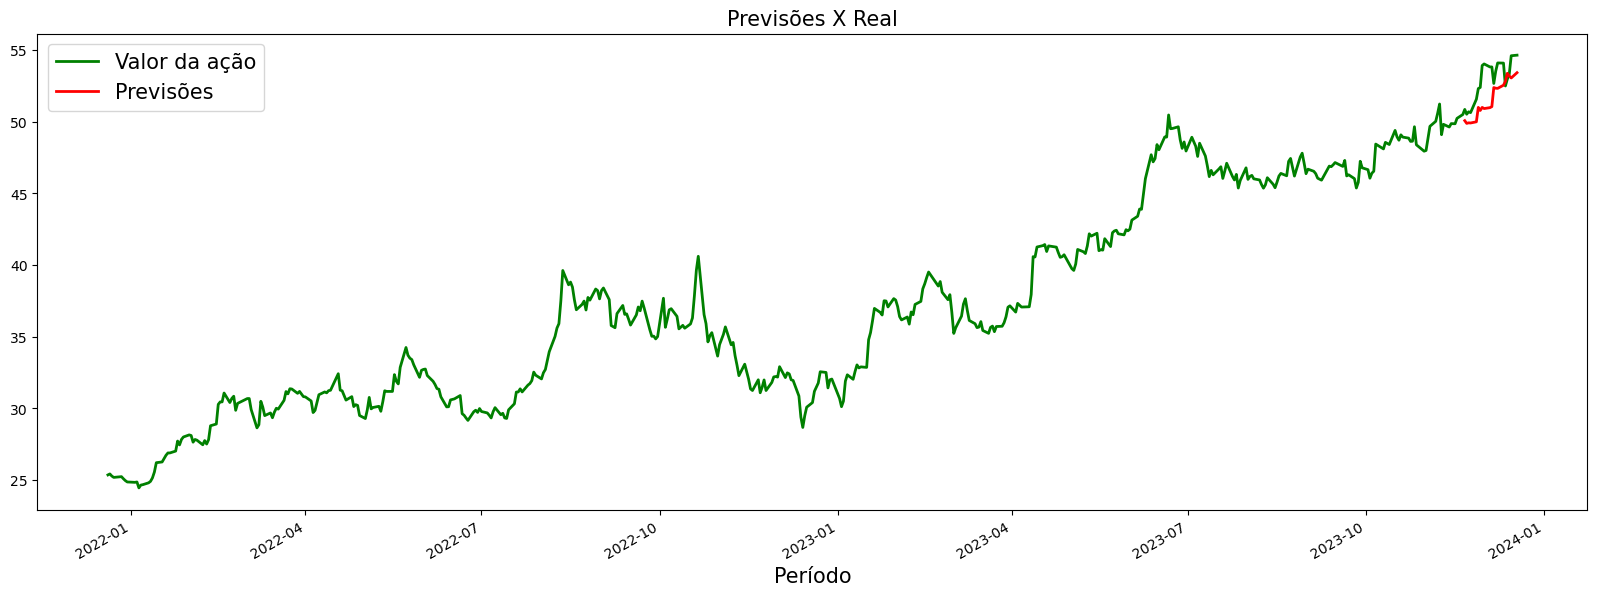

In [21]:
pd.concat([data,previsao_final],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Valor da ação','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show()

In [214]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3236
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -891.686
Date:                            Fri, 08 Dec 2023   AIC                           1791.371
Time:                                    23:05:59   BIC                           1815.685
Sample:                                         0   HQIC                          1800.085
                                           - 3236                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9632      0.004    239.090      0.000       0.955       0.971
ar.S.L12      -0.6343      0.012    -54.276      0.000      -0.657      -0.611
ar.S.L24      -0.2903      0.012    -24.907      0.000      -0.313      -0.267
sigma2         0.1016      0.001     88.594      0.000       0.099       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):              8053.73
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.06
Prob(H) (two-sided):                  0.67   Kurtosis:                        10.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

pmdarima version: 2.0.4
[CV] fold=0 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=1 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=2 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=3 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=4 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=5 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=6 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=7 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=8 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=9 ..........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=10 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=11 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=12 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=13 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=14 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=15 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=16 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=17 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=18 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=19 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=20 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=21 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=22 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=23 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=24 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=25 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=26 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=27 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=28 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=29 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=30 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=31 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=32 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=33 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=34 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=35 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=36 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=37 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=38 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=39 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=40 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=41 .........................................................


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


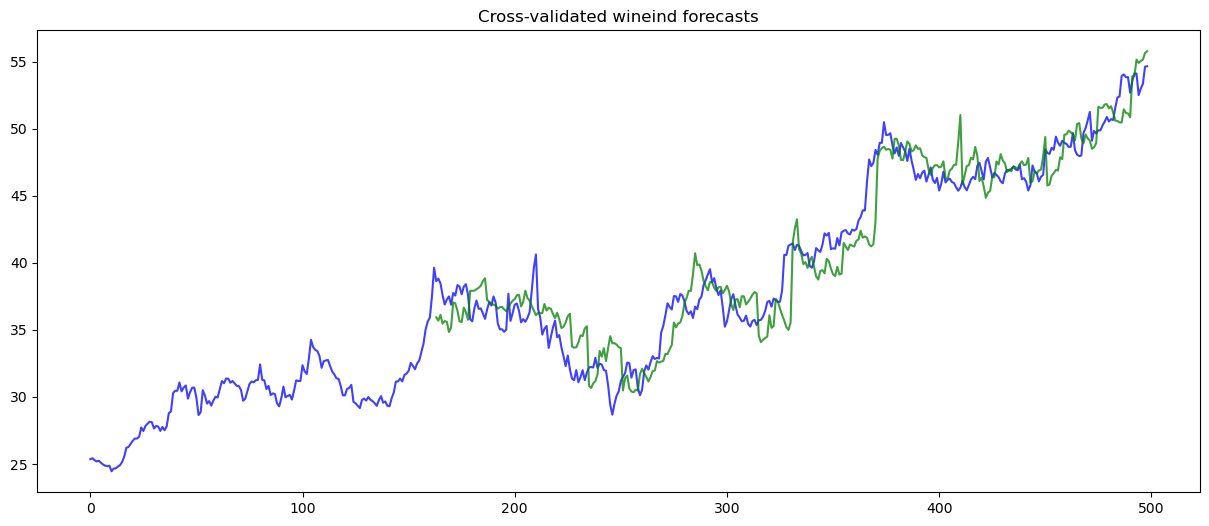

In [22]:
# ARIMA(1,0,0)(2,1,0)[40] intercept
from pmdarima import model_selection
print("pmdarima version: %s" % pm.__version__)

# Load the data and split it into separate pieces
y = data
est = pm.ARIMA(order=(1, 0, 0),
               seasonal_order=(2, 1, 0, 40),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=160, step=8, h=8)
predictions = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

# plot the predictions over the original series
x_axis = np.arange(y.shape[0])
n_test = predictions.shape[0]

plt.plot(x_axis, y, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated wineind forecasts")
plt.show()

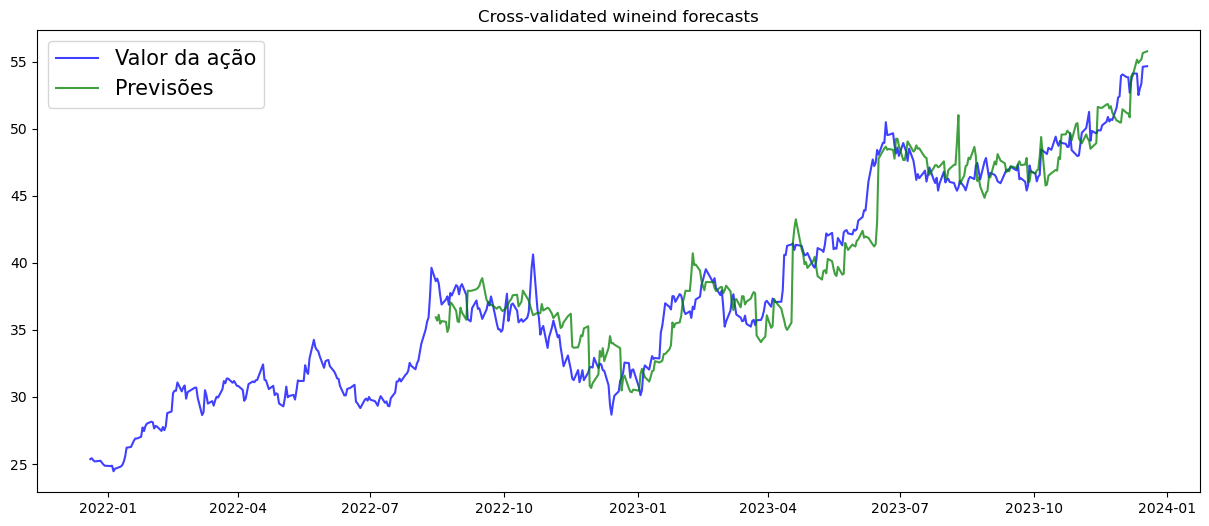

In [25]:
plt.plot(y.index, y, alpha=0.75, c='b')
plt.plot(y.index[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.legend(['Valor da ação','Previsões'], fontsize=15)
plt.title("Cross-validated wineind forecasts")
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

y_true = y[-n_test:]  # A parte dos dados que não foi usada para treinamento
mse = mean_squared_error(y_true, predictions)# ideal 0
mad = median_absolute_error(y_true, predictions)# ideal 0
mae = mean_absolute_error(y_true, predictions)# ideal 0
r2 = r2_score(y_true, predictions)# ideal 1

print(f'Mean Squared Error (MSE): {mse}')
print(f'Median Absolute Deviation (MAD): {mad}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 3.913682696687515
Median Absolute Deviation (MAD): 1.3565949640039996
Mean Absolute Error (MAE): 1.5860787792747484
R-squared (R²): 0.9081541365017687


c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


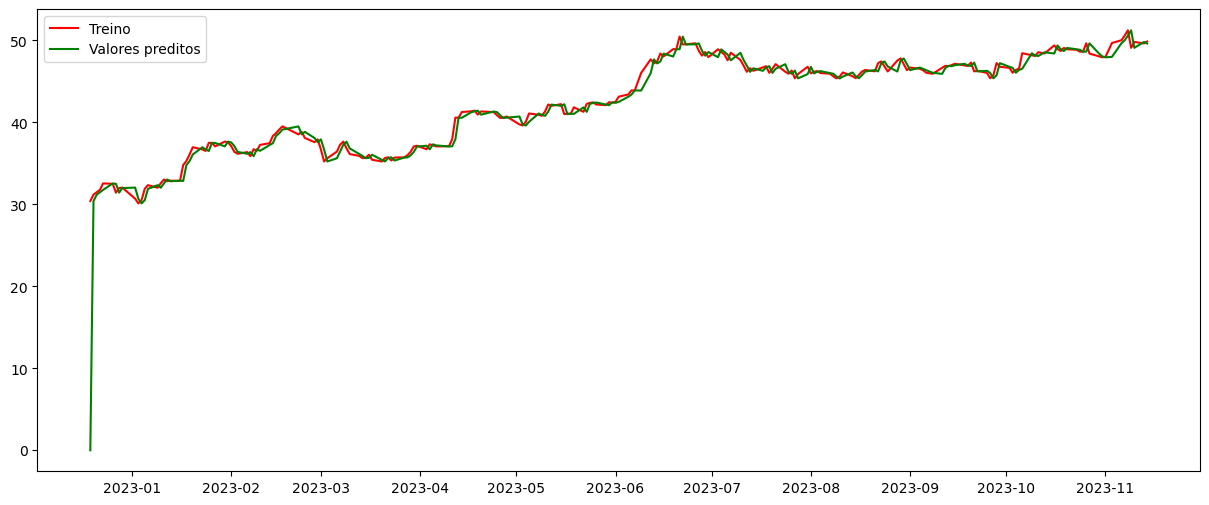

In [34]:
modelo = SARIMAX(treino, order=(1, 0, 1), seasonal_order=(0,0,0,0)).fit(disp=0)

predito = modelo.predict(typ='levels')
plt.plot(treino, color='red')
plt.plot(predito,color='green')
plt.legend(['Treino','Valores preditos'])

<AxesSubplot:>

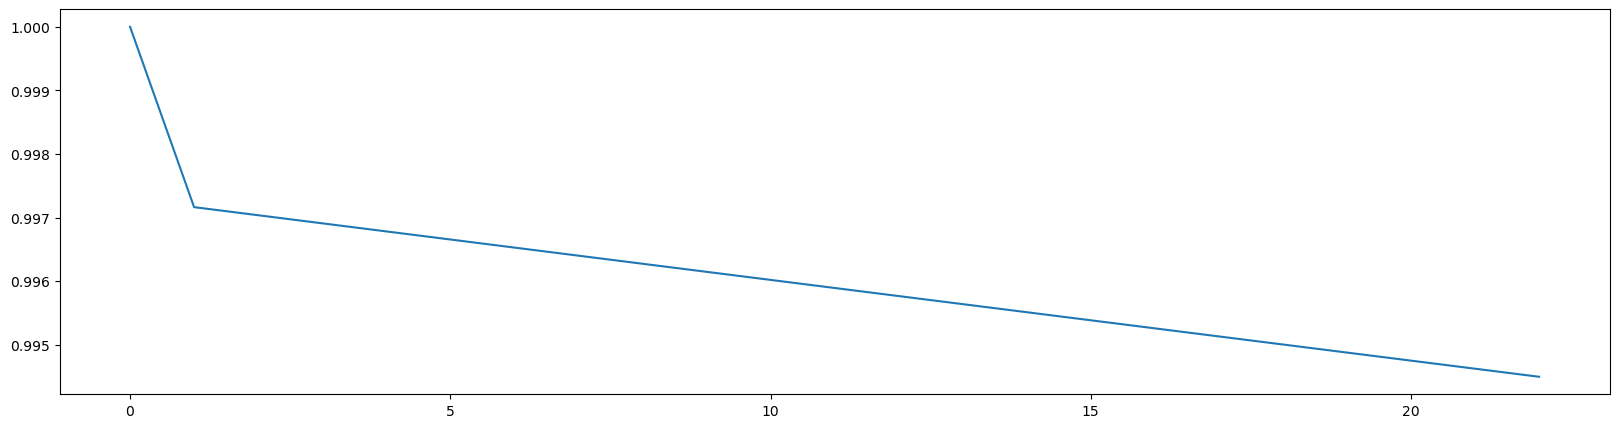

In [35]:
modelo.impulse_responses(steps=22).plot(figsize=(20,5))

In [36]:
print("RMSE do modelo (treino vs treinado): %.3f" % np.sqrt(mean_squared_error(treino, predito)))
print("R² do modelo (treino vs treinado): %.3f" % r2_score(treino, predito))
print(''*254)
print("RMSE do modelo (teste vs previsões): %.3f" % np.sqrt(mean_squared_error(teste, previsao)))
print("R² do modelo (teste vs previsões): %.3f" % r2_score(teste, previsao))

RMSE do modelo (treino vs treinado): 2.124
R² do modelo (treino vs treinado): 0.857

RMSE do modelo (teste vs previsões): 3.306
R² do modelo (teste vs previsões): -3.852


<AxesSubplot:xlabel='Date'>

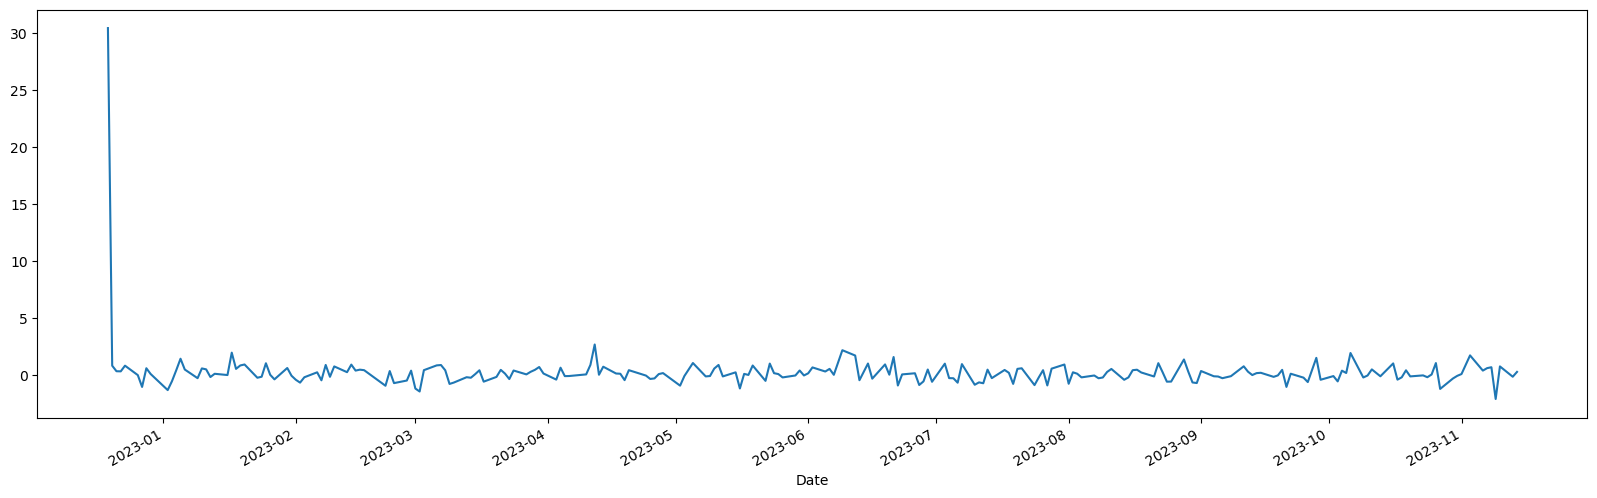

In [37]:
(treino['Adj Close'] - pd.DataFrame(predito)['predicted_mean']).plot(figsize=(20,6))

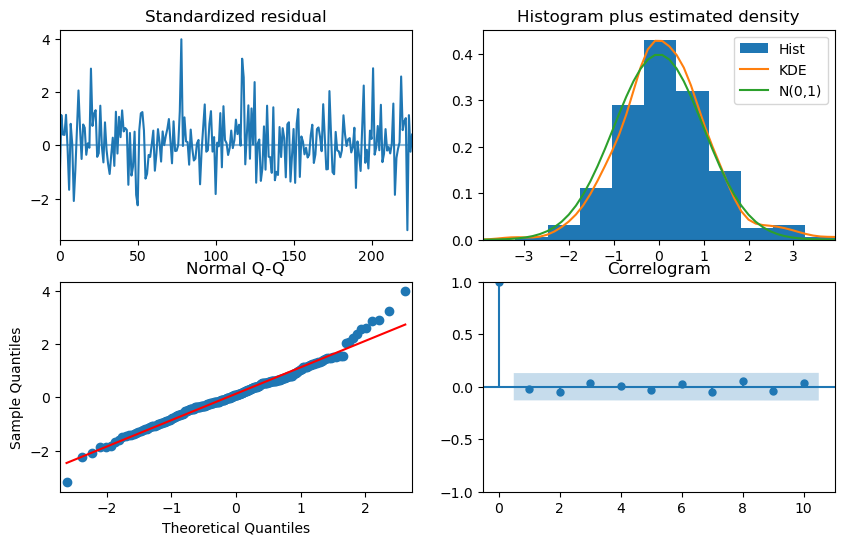

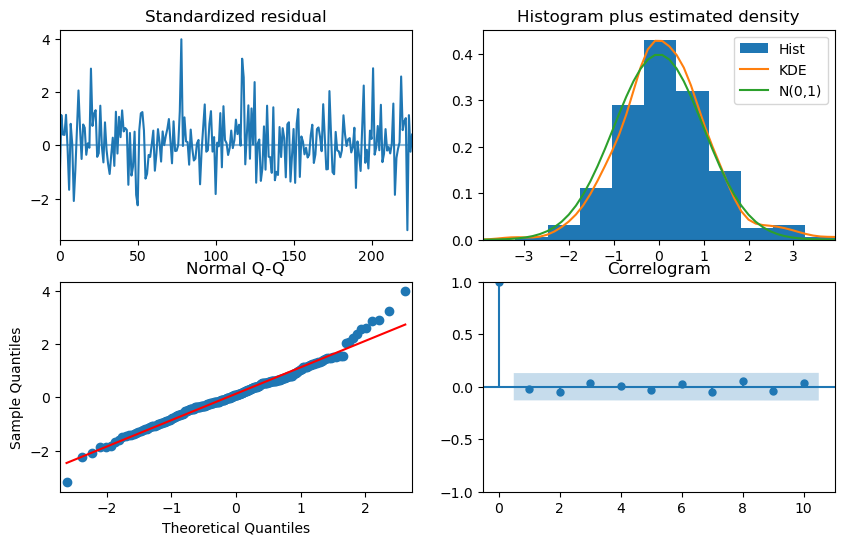

In [38]:
stepwise.plot_diagnostics(figsize=(10,6))